In [14]:
import numpy as np, h5py
from scipy.misc import imresize
from scipy.ndimage import zoom

from theano.tensor.nnet import relu

from deepgraph.utils import common
from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *
from deepgraph.utils.logging import *

In [24]:
def load_data(db_file):
    # Read the MAT-File into memory
    log("Loading data from database", LOG_LEVEL_INFO)
    dataset = h5py.File(db_file)

    depth_field = dataset['depths']
    depths = np.array(depth_field[0:200])

    images_field = dataset['images']
    images = np.array(images_field[0:200]).astype(np.uint8)

    # Swap axes
    images = np.swapaxes(images, 2, 3)
    depths = np.swapaxes(depths, 1, 2)

    # Resizing
    log("Resizing input", LOG_LEVEL_INFO)
    img_scale = 0.5
    depth_scale = 0.125

    images_sized = np.zeros((images.shape[0],images.shape[1], int(images.shape[2]*img_scale), int(images.shape[3]*img_scale)), dtype=np.uint8)
    depths_sized = np.zeros((depths.shape[0],int(depths.shape[1]*depth_scale), int(depths.shape[2]*depth_scale)), dtype=np.float32)

    for i in range(len(images)):
        ii = imresize(images[i], img_scale)
        images_sized[i] = np.swapaxes(np.swapaxes(ii,1,2),0,1)

    # For this test, we down-sample the depth images to 64x48

    for d in range(len(depths)):
        dd = zoom(depths[d], depth_scale)
        depths_sized[d] = dd

    images = images_sized
    depths = depths_sized

    images_train, images_val = common.split_array(images, 0.9)
    depths_train, depths_val = common.split_array(depths, 0.9)
    return [(images_train, images_val),(depths_train, depths_val)]

In [25]:
data = load_data('/home/ga29mix/nashome/data/nyu_depth_v2/nyu_depth_v2_labeled.mat')
# data = load_data('./data/nyu_depth_v2_labeled.mat')
train_x, val_x = data[0]
train_y, val_y = data[1]

[2016-03-28 11:27:31] INFO: Loading data from database
[2016-03-28 11:27:42] INFO: Resizing input


In [26]:
#######################
# Data preprocessing
#######################
log("Preprocessing data", LOG_LEVEL_INFO)

# X
# Scale into 0-1 range
train_x = train_x.astype(np.float32)
val_x = val_x.astype(np.float32)
# Subtract mean
train_mean = np.load("train_mean.npy").astype(np.float32)
idx = 0
for element in train_x:
    train_x[idx] = train_x[idx] - train_mean
    idx += 1
idx = 0
for element in val_x:
    val_x[idx] = val_x[idx].astype(np.float32) - train_mean

[2016-03-28 11:27:51] INFO: Preprocessing data


In [18]:
def build_graph():
    graph = Graph("depth_predictor")

    data            = Data(graph, "data", T.ftensor4, shape=(-1, 3, 240, 320))
    label           = Data(graph, "label", T.ftensor3, shape=(-1, 1, 60, 80), phase=PHASE_TRAIN)

    conv_0     = Conv2D(
        graph,
        "conv_0",
        n_channels=96,
        kernel_shape=(11, 11),
        subsample=(4, 4),
        activation=relu
    )
    pool_0 = Pool(graph, "pool_0", kernel_size=(3, 3), stride=(2, 2))
    lrn_0           = LRN(graph, "lrn_0")
    conv_1   = Conv2DPool(
        graph,
        "conv_1",
        n_channels=256,
        kernel_shape=(5, 5),
        border_mode=2,
        activation=relu
    )
    pool_1 = Pool(graph, "pool_1", kernel_size=(3, 3), stride=(2, 2))
    lrn_1           = LRN(graph, "lrn_1")
    conv_2          = Conv2D(
        graph,
        "conv_2",
        n_channels=384,
        kernel_shape=(3, 3),
        border_mode=1,
        activation=relu
    )
    conv_3          = Conv2D(
        graph,
        "conv_3",
        n_channels=384,
        kernel_shape=(3, 3),
        border_mode=1,
        activation=relu
     )
    conv_4          = Conv2D(
        graph,
        "conv_4",
        n_channels=256,
        kernel_shape=(3, 3),
        border_mode=1,
        activation=relu
    )
    pool_4 = Pool(graph, "pool_4", kernel_size=(3, 3), stride=(2, 2))
    flatten         = Flatten(graph, "flatten", dims=2)
    hidden_0        = FC(graph, "fc_0", n_out=4096, activation=None)
    dp_0            = Dropout(graph, "dp_0")
    hidden_1        = FC(graph, "fc_1", n_out=4800, activation=None)
    rs              = Reshape(graph, "reshape_0", shape=(-1, 1, 60, 80), is_output=True)

    loss            = EuclideanLoss(graph, "loss", loss_weight=1.0)

    # Connect
    data.connect(conv_0)
    conv_0.connect(pool_0)
    pool_0.connect(lrn_0)
    lrn_0.connect(conv_1)
    conv_1.connect(pool_1)
    pool_1.connect(lrn_1)
    lrn_1.connect(conv_2)
    conv_2.connect(conv_3)
    conv_3.connect(conv_4)
    conv_4.connect(pool_4)
    pool_4.connect(flatten)
    flatten.connect(hidden_0)
    hidden_0.connect(dp_0)
    dp_0.connect(hidden_1)
    hidden_1.connect(rs)
    rs.connect(loss)
    label.connect(loss)

    return graph

In [19]:
model_file = "data/model.zip"
g = build_graph()
g.load_weights(model_file)

g.compile()

[2016-03-28 11:22:35] INFO: Fine-tuning from file 'data/model.zip'
[2016-03-28 11:22:35] INFO: Setting up graph
[2016-03-28 11:22:36] INFO: Invoking Theano compiler


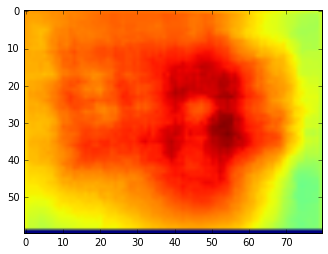

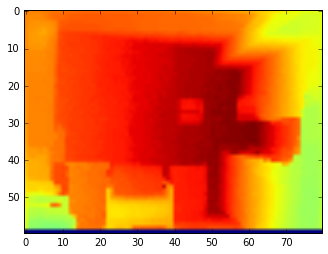

0.0209311


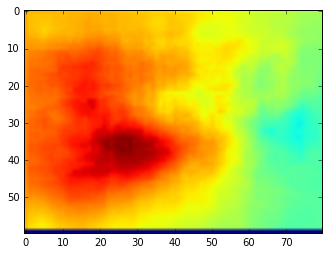

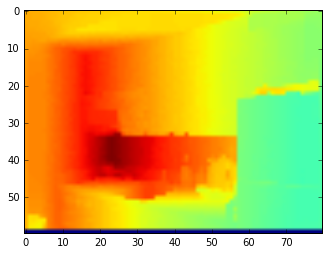

0.0108434


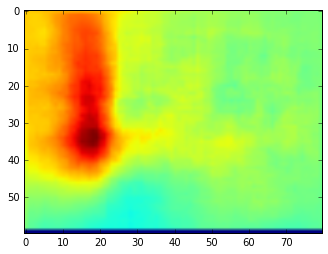

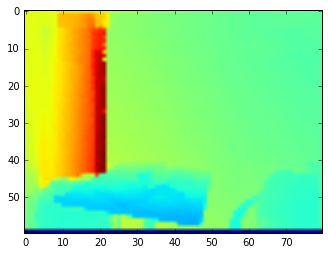

0.0339524


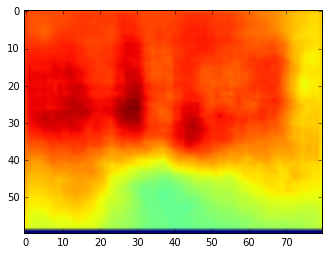

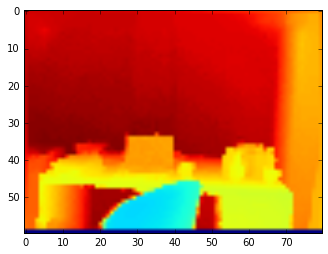

0.0379902


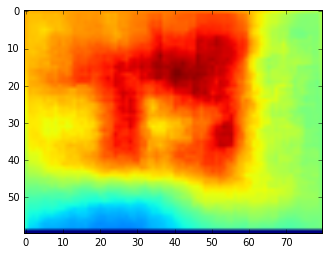

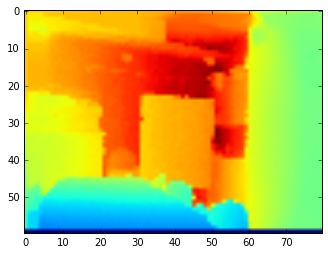

0.0603665


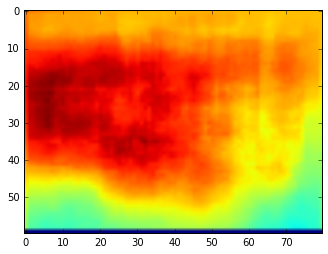

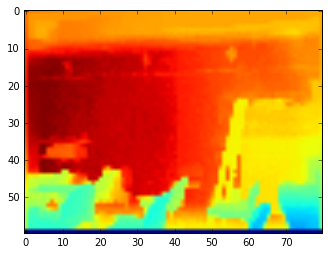

0.104455


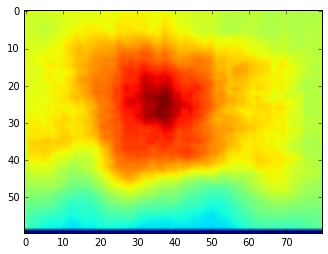

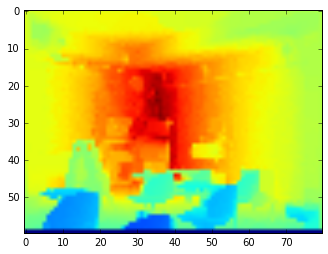

0.147125


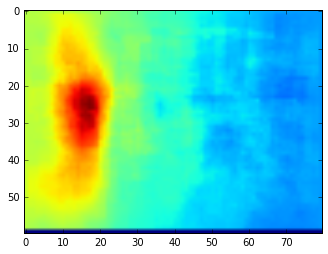

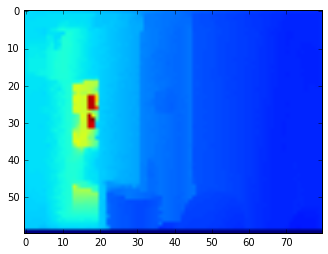

0.112296


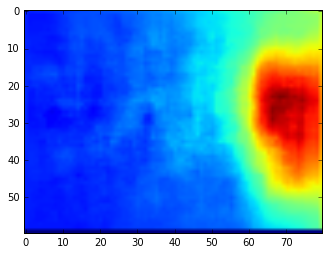

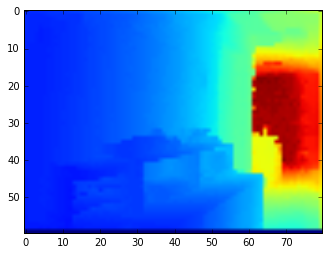

0.0694099


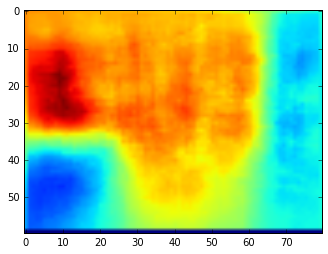

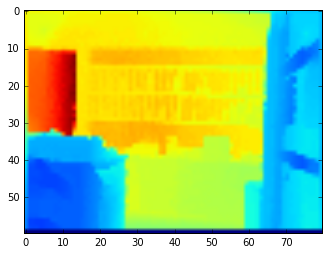

0.089492


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
Dropout.set_dp_off()

for j in range(10):
    sample = train_x[j]
    res = g.infer([sample.reshape(-1,3,240,320)])[0]    
    plt.imshow(res[0].squeeze())
    plt.show()
    plt.imshow(train_y[j])
    plt.show()
    print ((res[0].squeeze() - train_y[j]) ** 2).mean()